In [12]:
import math
import random

import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns 

import numpy.random as nr
import numpy as np
import pandas as pd
import scipy.stats as ss

import sklearn.decomposition as skde
import sklearn.metrics as sklm
from sklearn import linear_model, kernel_ridge
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE

%matplotlib inline

In [13]:
train_values = pd.read_csv('train_values.csv')
train_values.sort_values(by='country_code', ascending=True, inplace=True) # sort by country_code to split by country
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv')

print(train_values.shape)
print(test_values.shape)

desc = train_values[train_values.columns.difference(['row_id'])].describe(percentiles=[]).transpose().round(2)
desc['features'] = desc.index

fig = plt.figure(dpi=600) # define plot area
cell_text = []
for row in range(len(desc)):
    cell_text.append(desc.iloc[row])

table = plt.table(cellText=cell_text, colLabels=desc.columns,
                  colWidths=[0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.8], loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1.5, 2.5)
plt.axis('off')
plt.show()

(1401, 46)
(616, 46)


In [14]:
# drop features with more than 30% missing data
depth = len(train_values.row_id)
columns = []
drops = []
for col in train_values.columns.difference(['row_id', 'country_code']):
    count = 0
    count = [count + 1 for x in train_values[col] if math.isnan(x)]
    columns.append([col, sum(count)/depth*100])
columns.sort(key = lambda x: x[1])
print('Remove these features')
for col in columns:
    if col[1] > 30:
        drops.append(col[0])
        print(col[0])
        
train_values.drop(drops, 1, inplace=True)
test_values.drop(drops, 1, inplace=True)

Remove these features
school_enrollment_rate_total
tax_revenue_share_gdp
school_enrollment_rate_female
rail_lines_density
inequality_index
adult_literacy_rate
droughts_floods_extreme_temps


In [15]:
# visualization for train_values
def plot_histogram(train_values, cols, bins, n_rows, n_cols):
    fig = plt.figure(figsize=(16, 16), dpi=600) # define plot area
    ay = fig.gca() # define axis
    ay.xaxis.set_visible(False)  # hide the x axis
    ay.yaxis.set_visible(False)  # hide the y axis
    for i, col in enumerate(cols):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        train_values[col].plot.hist(ax=ax, bins=bins) # Use the plot.hist method on subset of the data frame
        ax.set_xlabel(col) # Set text for the x axis
    fig.tight_layout()  # Improves appearance a bit
    plt.show()

columns = list(train_values.columns.difference(['row_id', 'country_code', 'year']))
plot_histogram(train_values, columns, 16, 12, 4)

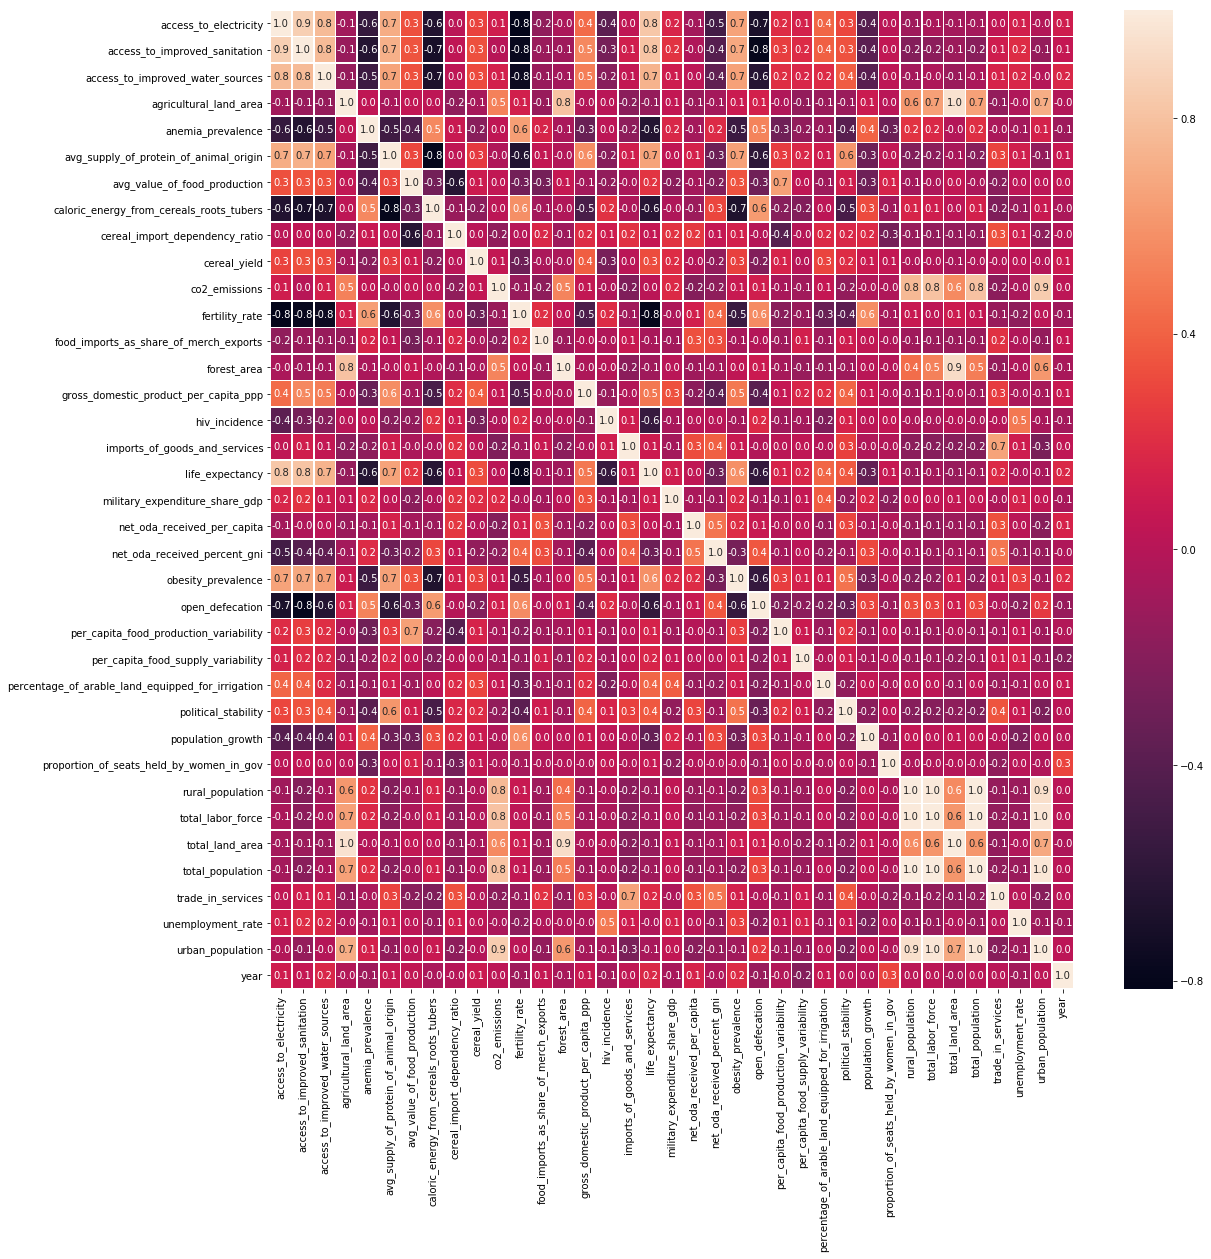

In [16]:
#correlation map
x = train_values[train_values.columns.difference(['row_id', 'country_code'])]
x.head()

f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [17]:
# get highest correlations from the map
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=4):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print('Top absolute correlations')
print(get_top_abs_correlations(x, 20))

Top absolute correlations
total_labor_force                       total_population                            0.997911
rural_population                        total_population                            0.993388
                                        total_labor_force                           0.989707
total_labor_force                       urban_population                            0.974371
total_population                        urban_population                            0.972803
agricultural_land_area                  total_land_area                             0.954624
rural_population                        urban_population                            0.940436
forest_area                             total_land_area                             0.928500
access_to_electricity                   access_to_improved_sanitation               0.863503
co2_emissions                           urban_population                            0.850898
access_to_electricity                   life

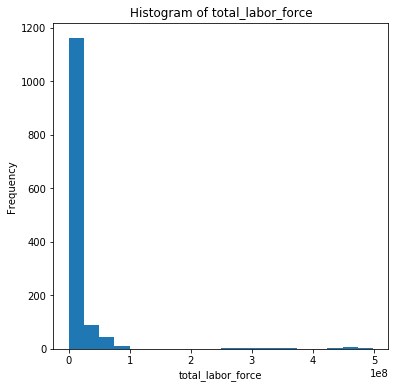

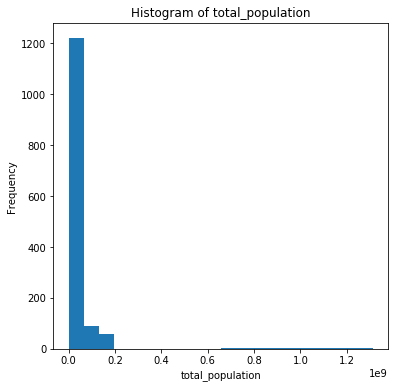

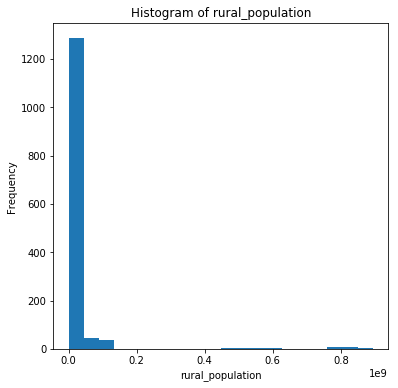

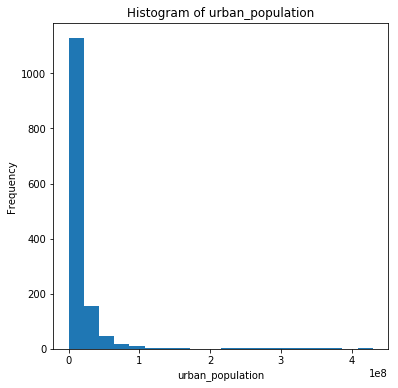

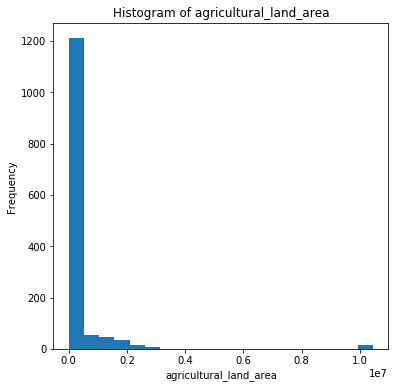

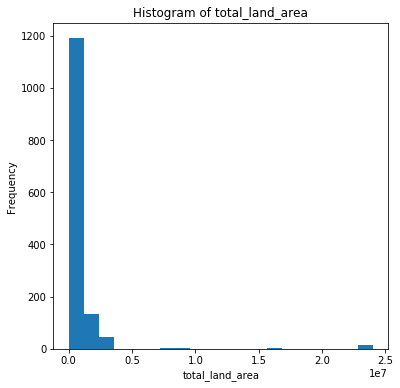

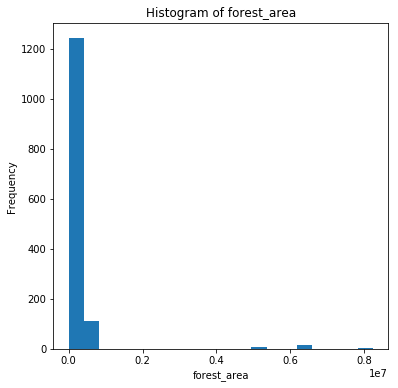

In [18]:
# visualization for train_values
def plot_histogram(train_values, cols, bins = 20):
    for col in cols:
        fig = plt.figure(figsize = (6,6)) # define plot area
        ax = fig.gca() # define axis    
        train_values[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        plt.show()

num_cols = list(['total_labor_force', 'total_population', 'rural_population', 'urban_population',
                 'agricultural_land_area', 'total_land_area', 'forest_area'])
plot_histogram(train_values, num_cols)

In [19]:
# drop highly corerlated features
drops = ['total_labor_force', 'rural_population', 'urban_population', 'agricultural_land_area', 'forest_area']
train_values.drop(drops, 1, inplace=True)
test_values.drop(drops, 1, inplace=True)

In [20]:
# replace missing values and remove outliers for train_values
random.seed(42)
for col in train_values.columns.difference(['row_id', 'country_code']):
    arr = np.array(train_values[col])
    elements = np.array(train_values[col])
    
    mean = np.mean(elements[~np.isnan(elements)])
    std = np.std(elements[~np.isnan(elements)])
    
    elements = [x for x in elements if x > mean - 2*std]
    elements = [x for x in elements if x < mean + 2*std]
    
    for i in range(len(arr)):
        if (math.isnan(arr[i]) == True) or (arr[i] not in elements):
            arr[i] = random.choice(elements) # randomized values
#             arr[i] = np.mean(elements) # mean values
    train_values[col] = arr

print(train_values.shape)
print(train_values.isnull().values.any())

# replace missing values and remove outliers for test_values
random.seed(42)
for col in test_values.columns.difference(['row_id', 'country_code']):
    arr = np.array(test_values[col])
    elements = np.array(test_values[col])
    
    mean = np.mean(elements[~np.isnan(elements)])
    std = np.std(elements[~np.isnan(elements)])
    
    elements = [x for x in elements if x > mean - 2*std]
    elements = [x for x in elements if x < mean + 2*std]
    
    for i in range(len(arr)):
        if (math.isnan(arr[i]) == True) or (arr[i] not in elements):
            arr[i] = random.choice(elements) # randomized values
#             arr[i] = np.mean(elements) # mean values
    test_values[col] = arr

print(test_values.shape)
print(test_values.isnull().values.any())

(1401, 34)
False
(616, 34)
False


In [21]:
# validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)


Model score: 0.5145 (0.1228)


Filtered importances 16


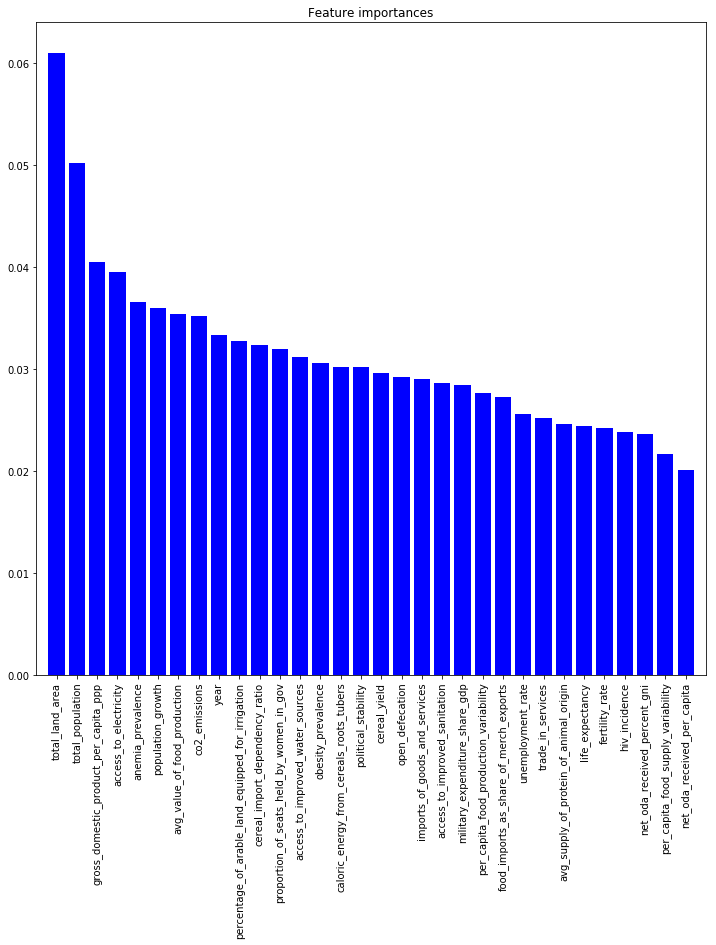

In [22]:
# features importance
from sklearn.ensemble import RandomForestRegressor

train_data = train_values.join(train_labels.set_index('row_id'), on='row_id')
x_train = train_data[train_data.columns.difference(['row_id', 'country_code', 'prevalence_of_undernourishment'])]
x_train_columns = train_data[train_data.columns.difference(['row_id', 'country_code', 'prevalence_of_undernourishment'])].columns
y_train = train_data.prevalence_of_undernourishment

model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=42, nthread=-1)

# transformation before training
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=42)
x_train = quantile_transformer.fit_transform(x_train)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
y_train = np.log1p(y_train)

model = model_xgb
model.fit(x_train, y_train)

score = rmsle_cv(model)
print("\nModel score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

importances = model.feature_importances_
filtered_importances = [x for x in importances if x > 0.030]
best_no_features = len(filtered_importances)
print("\nFiltered importances " + str(len(filtered_importances)))
indices = np.argsort(importances)[::-1]

plt.figure(1, figsize=(12, 12))
plt.title('Feature importances')
plt.bar(range(x_train.shape[1]), importances[indices],
        color='b', align='center')
plt.xticks(range(x_train.shape[1]), x_train_columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [23]:
# features selection by RFE
train_data = train_values.join(train_labels.set_index('row_id'), on='row_id')
columns = train_data.columns.difference(['row_id', 'country_code', 'prevalence_of_undernourishment'])
x_train = train_data[columns]
y_train = train_data.prevalence_of_undernourishment

# feature extraction
model = RandomForestRegressor()
rfe = RFE(model, best_no_features)
fit = rfe.fit(x_train, y_train)

for i in range(len(columns)):
    if not fit.support_[i]:
        train_values.drop(columns[i], 1, inplace=True)
        test_values.drop(columns[i], 1, inplace=True)
        print('Drop ' + columns[i])
    else:
        print('Keep ' + columns[i])

Keep access_to_electricity
Keep access_to_improved_sanitation
Keep access_to_improved_water_sources
Keep anemia_prevalence
Drop avg_supply_of_protein_of_animal_origin
Keep avg_value_of_food_production
Keep caloric_energy_from_cereals_roots_tubers
Drop cereal_import_dependency_ratio
Keep cereal_yield
Keep co2_emissions
Drop fertility_rate
Drop food_imports_as_share_of_merch_exports
Keep gross_domestic_product_per_capita_ppp
Drop hiv_incidence
Drop imports_of_goods_and_services
Drop life_expectancy
Drop military_expenditure_share_gdp
Drop net_oda_received_per_capita
Drop net_oda_received_percent_gni
Keep obesity_prevalence
Keep open_defecation
Drop per_capita_food_production_variability
Drop per_capita_food_supply_variability
Keep percentage_of_arable_land_equipped_for_irrigation
Drop political_stability
Keep population_growth
Drop proportion_of_seats_held_by_women_in_gov
Keep total_land_area
Keep total_population
Drop trade_in_services
Keep unemployment_rate
Drop year


In [24]:
# recreate data subsets for predictive models
train_data = train_values.join(train_labels.set_index('row_id'), on='row_id')

print(train_values.shape)
print(test_values.shape)
print(train_data.shape)

group_train_data = train_data.drop(['row_id', 'country_code'], 1)

x_train = np.array(group_train_data.drop('prevalence_of_undernourishment', 1))
y_train = np.array(group_train_data.prevalence_of_undernourishment)
x_score = np.array(test_values.drop(['row_id', 'country_code'], 1))

print(x_train.shape)
print(y_train.shape)
print(x_score.shape)

(1401, 18)
(616, 18)
(1401, 19)
(1401, 16)
(1401,)
(616, 16)


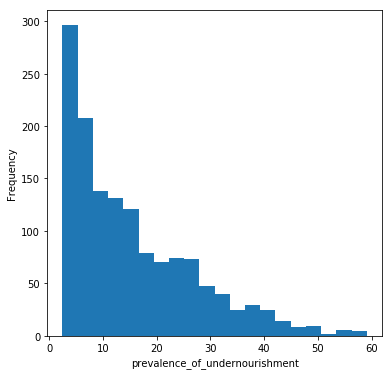

In [25]:
def plot_histogram(train_data, cols, bins = 20):
    for col in cols:
        fig = plt.figure(figsize = (6,6)) # define plot area
        ax = fig.gca() # define axis    
        train_data[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_xlabel(col) # Set text for the x axis
        plt.show()
        
num_cols = ['prevalence_of_undernourishment']
plot_histogram(train_data, num_cols)

In [41]:
# transformation before training
# quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=42)
# x_train = quantile_transformer.fit_transform(x_train)
# x_score = quantile_transformer.fit_transform(x_score)

scaler_train = preprocessing.StandardScaler().fit(x_train)
x_train = scaler_train.transform(x_train)
scaler_score = preprocessing.StandardScaler().fit(x_score)
x_score = scaler_score.transform(x_score)

y_train = np.log1p(y_train)

In [42]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=23):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, x, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=False, random_state=42)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((x.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(x, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(x[train_index], y[train_index])
                y_pred = instance.predict(x[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, x):
        meta_features = np.column_stack([
            np.column_stack([model.predict(x) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [43]:
model_nn_1 = MLPRegressor(hidden_layer_sizes=(6,), max_iter=30000)
model_nn_2 = MLPRegressor(hidden_layer_sizes=(6, 4), max_iter=30000)
model_nn_3 = MLPRegressor(hidden_layer_sizes=(6, 4, 2), max_iter=30000)
lasso = linear_model.Lasso(alpha=0.0005, random_state=42)
ENet = linear_model.ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=42)
model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=42, nthread=-1)
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [44]:
# score = rmsle_cv(model_nn_1)
# print("Neural Network_1 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_nn_2)
print("Neural Network score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(model_nn_3)
# print("Neural Network_3 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Neural Network score: 0.2032 (0.0460)

Lasso score: 0.1485 (0.0349)

ElasticNet score: 0.1486 (0.0349)

Kernel Ridge score: 0.1749 (0.0392)

XGBoost score: 0.1522 (0.0317)

LGBM score: 0.1606 (0.0266)



In [45]:
# # optimize Neural Network
# param_grid = {'hidden_layer_sizes': [(6, 4)],'activation': ['identity', 'logistic', 'tanh', 'relu'], 
#               'early_stopping': [True, False],
#               'beta_1': [0.75, 0.8, 0.85, 0.9], 'beta_2': [0.85, 0.9, 0.99, 0.999], 'early_stopping': [True],
#               'alpha': [0.0001, 0.0005, 0.001, 0.002]}

# kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
# grid = GridSearchCV(estimator=model_nn_2, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
#                       ,verbose=2)
# grid.fit(x_train, y_train)
# model_nn_2 = grid.best_estimator_
# # print(grid.best_params_)

# score = rmsle_cv(model_nn_2)
# print("Neural Network score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [46]:
# optimize Lasso
param_grid = {'alpha': [0.0001, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16]}

kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
grid.fit(x_train, y_train)
lasso = grid.best_estimator_
print(grid.best_params_)

score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'alpha': 0.01}
Lasso score: 0.1434 (0.0350)



[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished


In [47]:
# optimize Elastic net
param_grid = {'alpha': [0.0001, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16],
              'l1_ratio': [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]}

kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
grid = GridSearchCV(estimator=ENet, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
grid.fit(x_train, y_train)
ENet = grid.best_estimator_
print(grid.best_params_)

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Fitting 5 folds for each of 49 candidates, totalling 245 fits
{'alpha': 0.02, 'l1_ratio': 0.7}
ElasticNet score: 0.1426 (0.0354)



[Parallel(n_jobs=1)]: Done 245 out of 245 | elapsed:    0.3s finished


In [48]:
# # optimize Kernel Ridge
# param_grid = {'alpha': [0.0001, 0.005, 0.01, 0.02, 0.04, 0.08, 0.16], 'degree': [2, 3, 4, 5], 'coef0': [2, 3, 4, 5, 6]}

# kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
# grid = GridSearchCV(estimator=KRR, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)
# grid.fit(x_train, y_train)
# KRR = grid.best_estimator_
# print(grid.best_params_)

# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [49]:
# # optimize Gradient Boosting
# param_grid = {'n_estimators': [3000], 'max_depth': [3, 4, 5, 6], 'min_samples_leaf': [10, 15, 20, 25],
#               'min_samples_split': [5, 10, 15, 20]}

# kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
# grid = GridSearchCV(estimator=GBoost, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
#                       ,verbose=2)
# grid.fit(x_train, y_train)
# GBoost = grid.best_estimator_
# print(grid.best_params_)

# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [50]:
# optimize Xgboost
param_grid = {'min_child_weight': [1, 5, 10],'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5]}

kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
grid = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
                      ,verbose=2)
grid.fit(x_train, y_train)
model_xgb = grid.best_estimator_
print(grid.best_params_)

score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 26.9min finished


{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6}
XGBoost score: 0.1491 (0.0361)



In [51]:
# # optimize LGBM
# param_grid = {'num_leaves': [4, 5], 'n_estimators': [700], 'max_bin': [40, 50],
#               'bagging_fraction': [0.8], 'bagging_freq': [3, 4], 'feature_fraction': [0.25, 0.35],
#               'feature_fraction_seed': [8, 9], 'bagging_seed': [9], 'min_data_in_leaf': [4, 5],
#               'min_sum_hessian_in_leaf': [10, 11]}

# kf = KFold(n_folds, shuffle=False, random_state=42).get_n_splits(x_train)
# grid = GridSearchCV(estimator=model_lgb, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
#                       ,verbose=2)
# grid.fit(x_train, y_train)
# model_lgb = grid.best_estimator_
# print(grid.best_params_)

# score = rmsle_cv(model_lgb)
# print("LGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [52]:
stacked_averaged_models_1 = StackingAveragedModels(base_models=(model_xgb, ENet),
                                                   meta_model=lasso)
stacked_averaged_models_2 = StackingAveragedModels(base_models=(lasso, ENet),
                                                   meta_model=model_xgb)
stacked_averaged_models_3 = StackingAveragedModels(base_models=(model_xgb, lasso),
                                                   meta_model=ENet)

score = rmsle_cv(stacked_averaged_models_1)
print("Stacking Averaged models_1 score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(stacked_averaged_models_2)
print("Stacking Averaged models_2 score: {:.4f} ({:.4f})".format(score.mean(), score.std()))
score = rmsle_cv(stacked_averaged_models_3)
print("Stacking Averaged models_3 score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models_1 score: 0.1646 (0.0342)
Stacking Averaged models_2 score: 0.1454 (0.0352)
Stacking Averaged models_3 score: 0.1837 (0.0344)


Mean Square Error      = 181.4283148082238
Root Mean Square Error = 13.469532835559807
Mean Absolute Error    = 11.336848425455727
Median Absolute Error  = 8.781517693665315


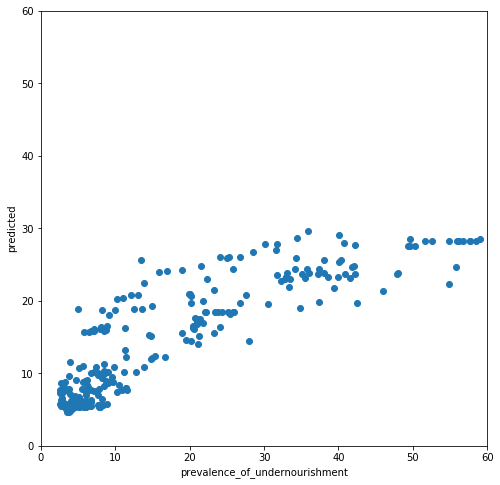

In [70]:
stacked_averaged_models_2.fit(x_train, y_train)
model_xgb.fit(x_train, y_train)

_, x_test, _, y_test = train_test_split(x_train, y_train, test_size=0.20, shuffle=False, random_state=42)
y_predicted = 0.1*np.expm1(np.expm1(stacked_averaged_models_2.predict(x_test))) + 0.9*np.expm1(np.expm1(model_xgb.predict(x_test)))

# print the usual metrics and the R^2 values
print('Mean Square Error      = ' + str(sklm.mean_squared_error(np.expm1(y_test), y_predicted)))
print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(np.expm1(y_test), y_predicted))))
print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(np.expm1(y_test), y_predicted)))
print('Median Absolute Error  = ' + str(sklm.median_absolute_error(np.expm1(y_test), y_predicted)))

fig = plt.figure(figsize = (8,8)) # define plot area
ax = fig.gca() # define axis
plt.scatter(np.expm1(np.expm1(y_test)), y_predicted)
plt.xlabel('prevalence_of_undernourishment')
plt.ylabel('predicted')
plt.xlim(0, 60)
plt.ylim(0, 60) 
plt.show()

In [72]:
y_score = 0.1*np.expm1(np.expm1(stacked_averaged_models_2.predict(x_score))) + 0.9*np.expm1(np.expm1(model_xgb.predict(x_score)))

sub = pd.read_csv('submission_format.csv')
sub.prevalence_of_undernourishment = y_score
sub.to_csv('submission.csv', encoding='utf-8', index=False)